In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koodikirjasto as kk
from scipy.stats import chi2_contingency
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# TJTS490 Harjoitustyö
### Susanna Lähde & Aatu Laitinen

Data koostettu:

https://www.avoindata.fi/data/fi/dataset/ajoneuvojen-avoin-data/resource/00041d67-966e-48cf-a720-255faf09d55c?
https://www.aut.fi/tilastot/ensirekisteroinnit/henkiloautojen_vuosittaiset_merkki-_ja_mallitilastot

Data koostettiin useammasta lähteestä, koska pääasiallisen datalähteen data oli puutteellista vuodesta 2017 lähtien. 

Ajatellaan, että olemme autojen jälleenmyyjä ja vaihtoautokauppa. Toimimme Suomen suurimmissa kaupunkikeskuksissa.

Meidän liiketoiminnan jatkuuvuden kannalta tärkeimmät tutkimuskysymykset ovat:
1. Markkinatrendit

    Minkä merkkisiä vaihtoautoja kannattaa hankkia?

    Mitä automerkkejä kannattaisi jälleenmyydä?

    Kannattaako myymälöihin hankkia myös sähköautoja?
   
2. Alueelliset erot

    Onko merkkien kysynnässä alueellisia eroja?


# Datan puutteet

<Axes: title={'center': 'Ensirekisteröintien määrät'}>

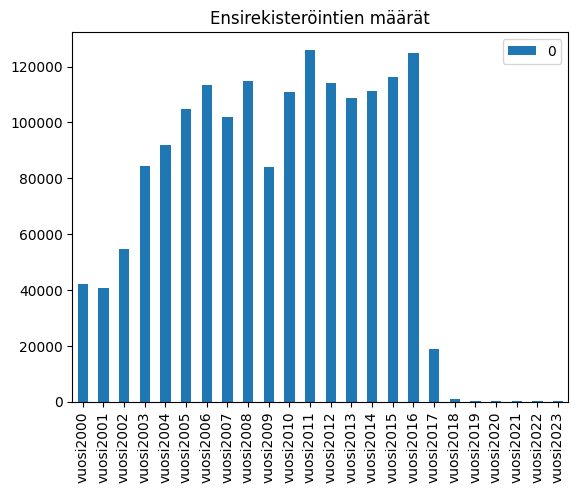

In [17]:
df = kk.ensirekisteroinnit_vuosittain_henkiloauto_luokassa(2000, 2023)
df.drop(columns="yhteensa").transpose().astype("float").plot(kind="bar", title="Ensirekisteröintien määrät")

Kuten ylläolevasta taulukosta näkyy, niin data on puutteellista vuodesta 2017 alkaen. Tämän takia tuoreempia myyntitilastoja koostettiin toisesta lähteestä

In [3]:
df = kk.datan_puutteellisuus_kolumnittain_henkiloauto_luokassa()
df

Cursor created successfully


,merkki,vari,korityyppi,ohjaamotyyppi,istumapaikkojenlkm,omamassa,kayttovoima,iskutilavuus,suurinnettoteho,sylintereidenlkm,ahdin,vaihteisto,vaihteidenlkm,kunta,mittarilukema,yhteensa
0,39,8862,243339,1562005,812,75,28,1164,94216,131159,694816,893553,1001176,27,75570,1898012
1,99.9979,99.5331,87.1793,17.7031,99.9572,99.9960,99.9985,99.9387,95.0361,93.0897,63.3924,52.9216,47.2513,99.9986,96.0185,0


Ylemmällä rivillä näkyy tyhjien arvojen määrä kolumnissa. Alemmalla rivillä näkyy prosenttiosuus ei-tyhjistä riveistä kolumnissa. 

Lähes jokaisessa kolumnissa on yli 90% täysiä arvoja (täysiä??). Kolumnissa ohjaamotyyppi on sen sijaan jopa 83% on tyhjiä (null) arvoja.

# Markkinatrendit
Tutkitaan miten eri merkkien määrä on kehittynyt vuosien varrella ja miten hybridiautojen määrä on kehittynyt.

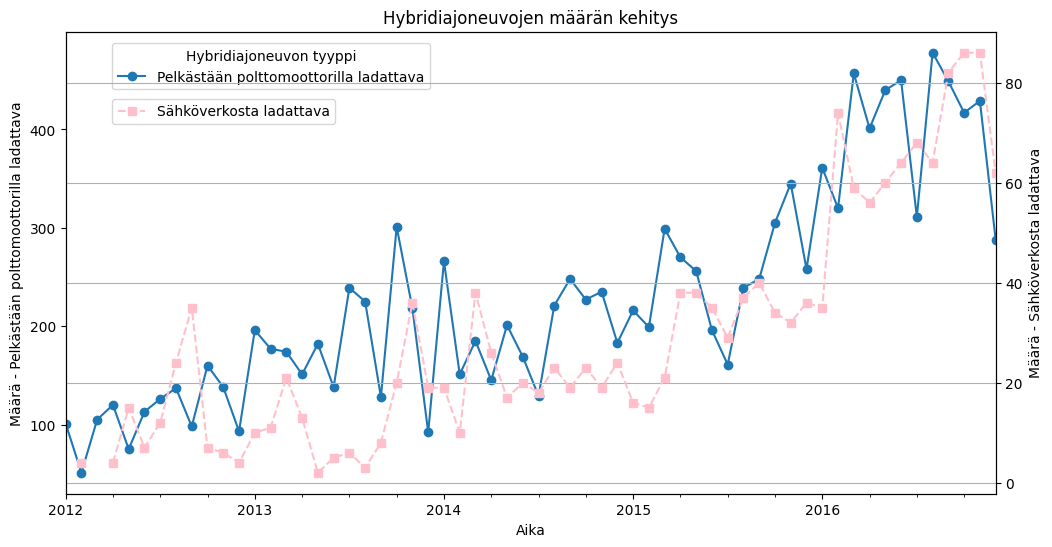

In [28]:
df = kk.hybridiautot_luokittain('M1', 2012, 2016)
df['date'] = pd.to_datetime(df['vuosi'].astype(str) + '-' + df['kuukausi'].astype(str), format='%Y-%m')
condition = df['hybridityyppi'] == 'Ei määritelty'
df = df[~condition]
df_pivot = df.pivot(index='date', columns='hybridityyppi', values='maara')
fig, ax1 = plt.subplots(figsize=(12, 6))

df_pivot.plot(ax=ax1, y='Pelkästään polttomoottorilla ladattava', marker='o', label='Pelkästään polttomoottorilla ladattava')
ax1.set_title('Hybridiajoneuvojen määrän kehitys')
ax1.set_xlabel('Aika')
ax1.set_ylabel('Määrä - Pelkästään polttomoottorilla ladattava')
ax1.legend(title='Hybridiajoneuvon tyyppi',loc=(0.05, 0.875))

ax2 = ax1.twinx()
ax2.set_ylabel('Määrä - Sähköverkosta ladattava') 

#ax2.set_ylim(0, 200) 
df_pivot.plot(ax=ax2, y='Sähköverkosta ladattava', marker='s', linestyle='--', label='Sähköverkosta ladattava', color="pink")
# Creating a legend for the second axis
ax2.legend(loc=(0.05, 0.8))
plt.grid(True)
plt.show()

Molempien hybridityyppien määrä on kasvanut vuosien varrella ja trendi on selkeästi positiivinen. Kuitenkaan määrät eivät ole vielä erityisen suuria.

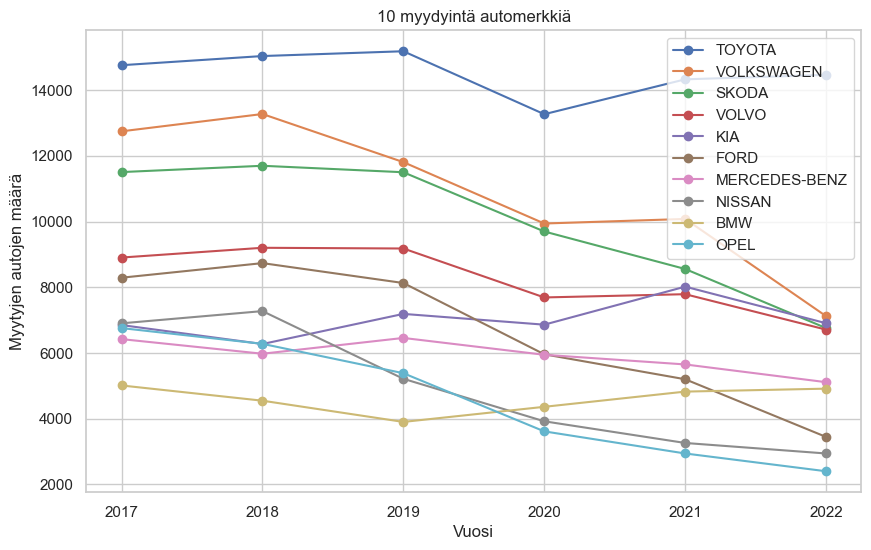

In [40]:
df = kk.ensirekisteroinnit_vuosittain(2017, 2022, 'merkki')
df['Total'] = df[df.columns[1:]].sum(axis=1)
df_sorted = df.sort_values(by='Total', ascending=False).head(10)
plt.figure(figsize=(10, 6))
for index, row in df_sorted.iterrows():
    plt.plot(df.columns[1:-1], row[1:-1], marker='o', label=row['merkki'])
plt.title('10 myydyintä automerkkiä')
plt.xlabel('Vuosi')
plt.ylabel('Myytyjen autojen määrä')
plt.legend()
plt.grid(True)
plt.show()

Visualisoidaan myös suhteellista muutosta, jolloin on helpompi nähdä yksittäisten merkkien trendit

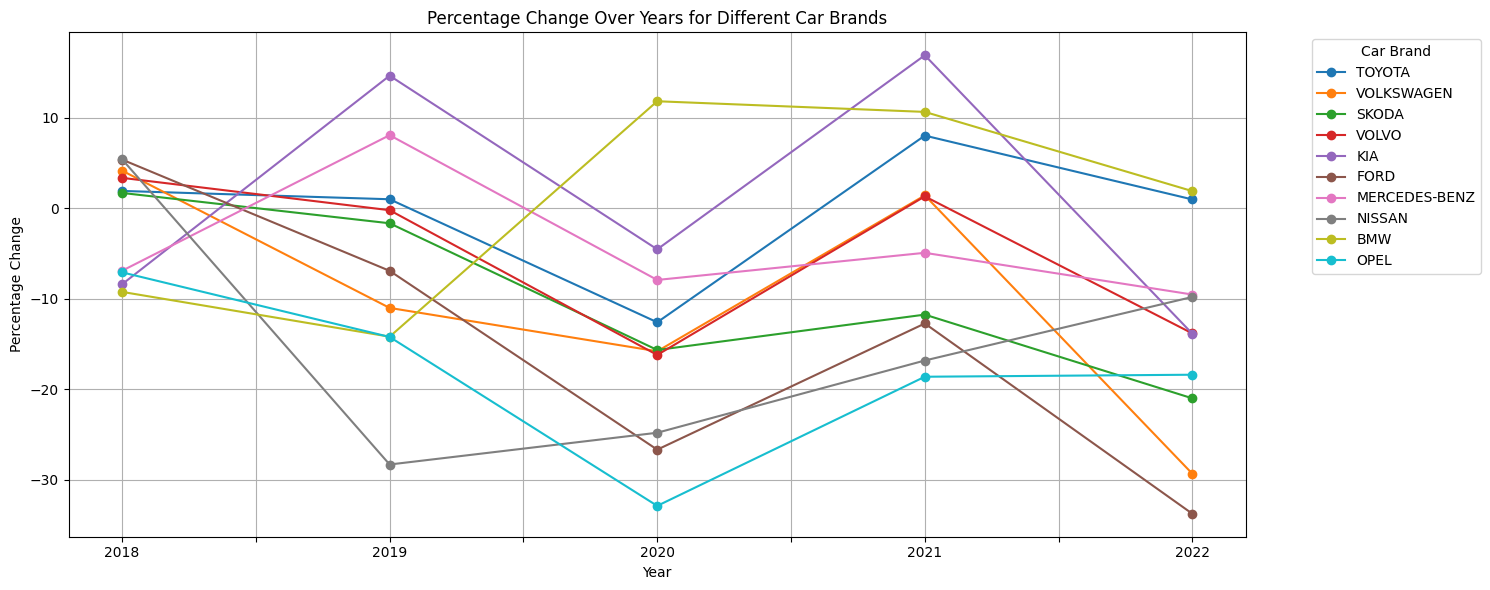

In [22]:
df = kk.ensirekisteroinnit_vuosittain(2017, 2022, 'merkki')
df['Total'] = df[df.columns[1:]].sum(axis=1)
df_sorted = df.sort_values(by='Total', ascending=False).head(10)
merkit = df_sorted["merkki"].values
df_pc_changes = df_sorted.drop(columns=["merkki", "Total"]).transpose().pct_change() * 100
df_pc_changes = df_pc_changes.transpose()
df_pc_changes["merkki"]= merkit
# Set the 'merkki' column as the index (assuming it represents the categories)
df_pc_changes.set_index('merkki', inplace=True)

# Transpose the DataFrame for easier plotting
df_transposed = df_pc_changes.transpose()

# Plot the data
plt.figure(figsize=(15, 6))
df_transposed.plot(marker='o', linestyle='-', ax=plt.gca())
plt.title('Percentage Change Over Years for Different Car Brands')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.legend(title='Car Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Suomalaisten suosituimpana automerkkinä on jo monen vuoden ajan pysynyt Toyota. Toisena ja kolmantena tulleiden merkkien Volkswagenin ja Skodan ensirekisteröintien määrät laskivat vuosien varrella monella tuhannella ja ovat nyt Kian ja Volvon kanssa samassa n. 7000 vuosittaisen ensirekisteröinni kanssa. Parin viimeisen vuoden aikana ainoastaan Toyota ja BMW ovat onnistuneet kasvattamaan ensirekisteröintiesä määrää edes vähän. Näiden brändien laskevat markkinaosuudet valuvat todennäköisesti muille brändeille ja erityisesti esimerkiksi uudemmille brändeille, kuten Teslalle, joka keskittyy pelkästään sähköautojen tuotantoon.


Tutkitaan seuraavaksi muutaman tunnetun sähköautomerkin ensirekisteröintien määrän muutosta.

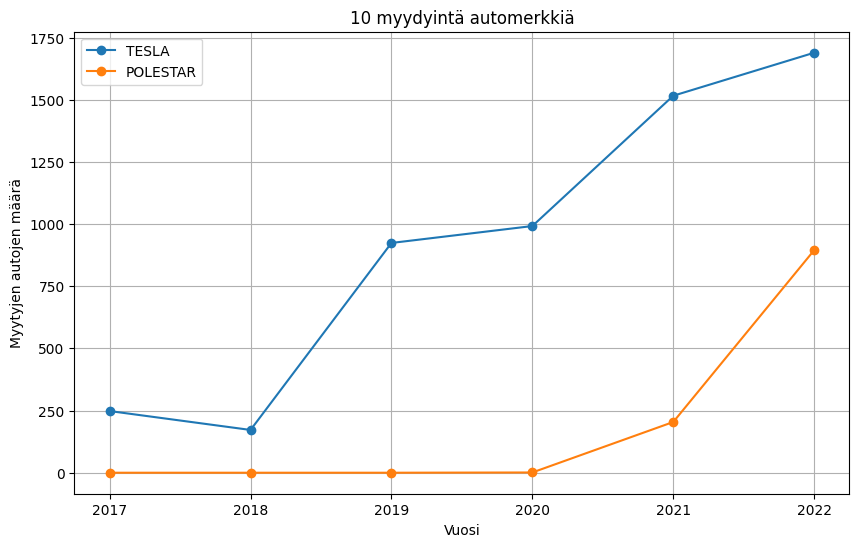

In [40]:
df = kk.ensirekisteroinnit_vuosittain(2017, 2022, 'merkki')
df['Total'] = df[df.columns[1:]].sum(axis=1)
sähköautomerkit = ["TESLA", "POLESTAR"]
df = df[df['merkki'].isin(sähköautomerkit)]
df_sorted = df.sort_values(by='Total', ascending=False).head(10)
plt.figure(figsize=(10, 6))
for index, row in df_sorted.iterrows():
    plt.plot(df.columns[1:-1], row[1:-1], marker='o', label=row['merkki'])
plt.title('10 myydyintä automerkkiä')
plt.xlabel('Vuosi')
plt.ylabel('Myytyjen autojen määrä')
plt.legend()
plt.grid(True)
plt.show()

Sähköautobrändien myynnin kasvu näyttää odotetunlaiselta.

# Alueelliset erot

Cursor created successfully


<Figure size 1500x800 with 0 Axes>

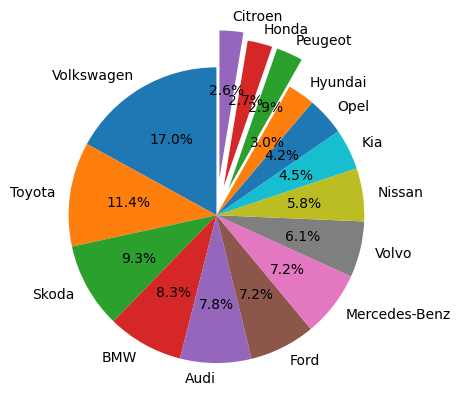

In [6]:
df = kk.ensirekisteroinnit_kunnittain_ajoneuvoluokassa("01.01.2010", "01.01.2016", "M1", "Espoo",False)
ensirekisteroinnit_kunnittain_ajoneuvoluokassa(pvm_alku, pvm_loppu, ajoneuvoluokka, kunta_lista, hae_malleittain)
df = df.iloc[:15]

plt.figure(figsize=(15, 8))

# Create a pie chart with exploded slices
explode = (0, 0, 0, 0, 0, 0, 0, 0,0 ,0, 0, 0, 0.2, 0.2 ,0.25)  # Adjust the explode values as needed
fig, ax = plt.subplots()
ax.pie(df["Määrä"], labels=df["Merkki"].values, autopct='%1.1f%%', startangle=90, explode=explode)


#ax.set_title('Ajoneuvoluokkien osuudet')

plt.show()



,Merkki,kunta,Määrä
0,Volkswagen,Tampere,3043
1,Toyota,Tampere,2662
2,Ford,Tampere,2246
3,Volkswagen,Jyväskylä,2184
4,Skoda,Tampere,1960


Text(0.5, 1.0, 'Top 10 Car Brands by City')

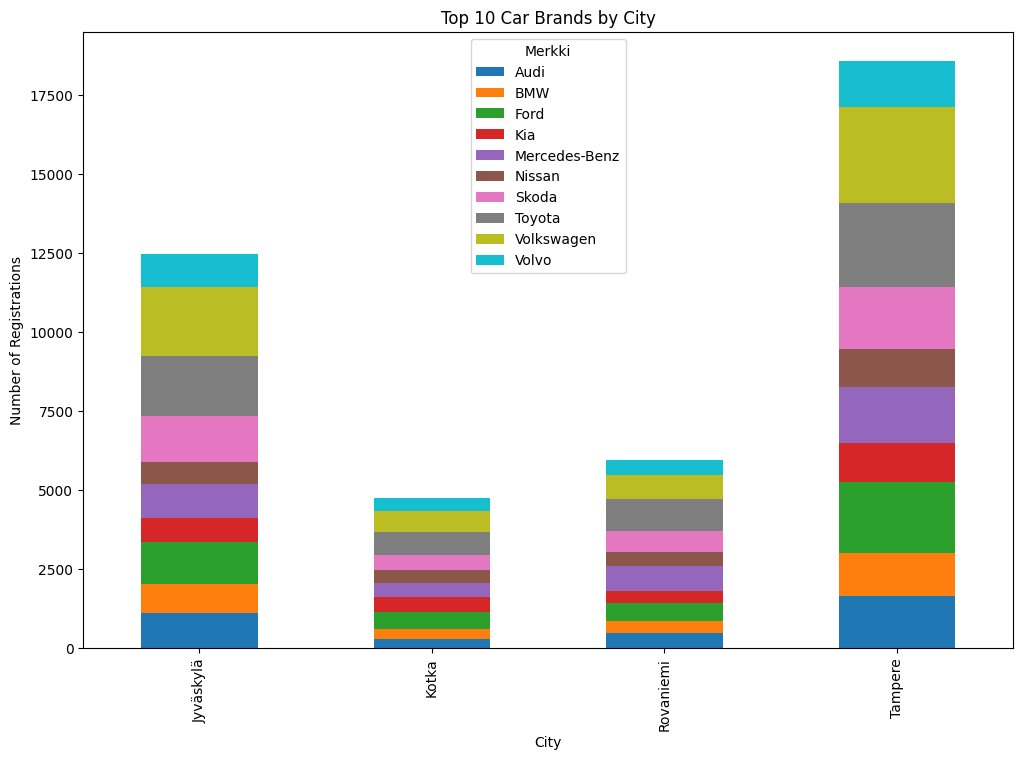

In [24]:
df = kk.ensirekisteroinnit_kunnittain_ajoneuvoluokassa("01.01.2010", "01.01.2016", "M1",["Rovaniemi", "Jyväskylä","Tampere","Kotka"], False)

# Calculate the total registrations for each car brand
brand_totals = df.groupby('Merkki')['Määrä'].sum()

# Get the top 10 most sold car brands
top_brands = brand_totals.sort_values(ascending=False).head(10).index

# Filter the DataFrame to include only the top 10 car brands
df_top10 = df[df['Merkki'].isin(top_brands)]

# Pivot the DataFrame to have cities as columns and car brands as rows
df_pivot = df_top10.pivot(index='kunta', columns='Merkki', values='Määrä')

# Plotting
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))

# Adding labels and title
ax.set_xlabel('City')
ax.set_ylabel('Number of Registrations')
ax.set_title('Top 10 Car Brands by City')

# Show the legend


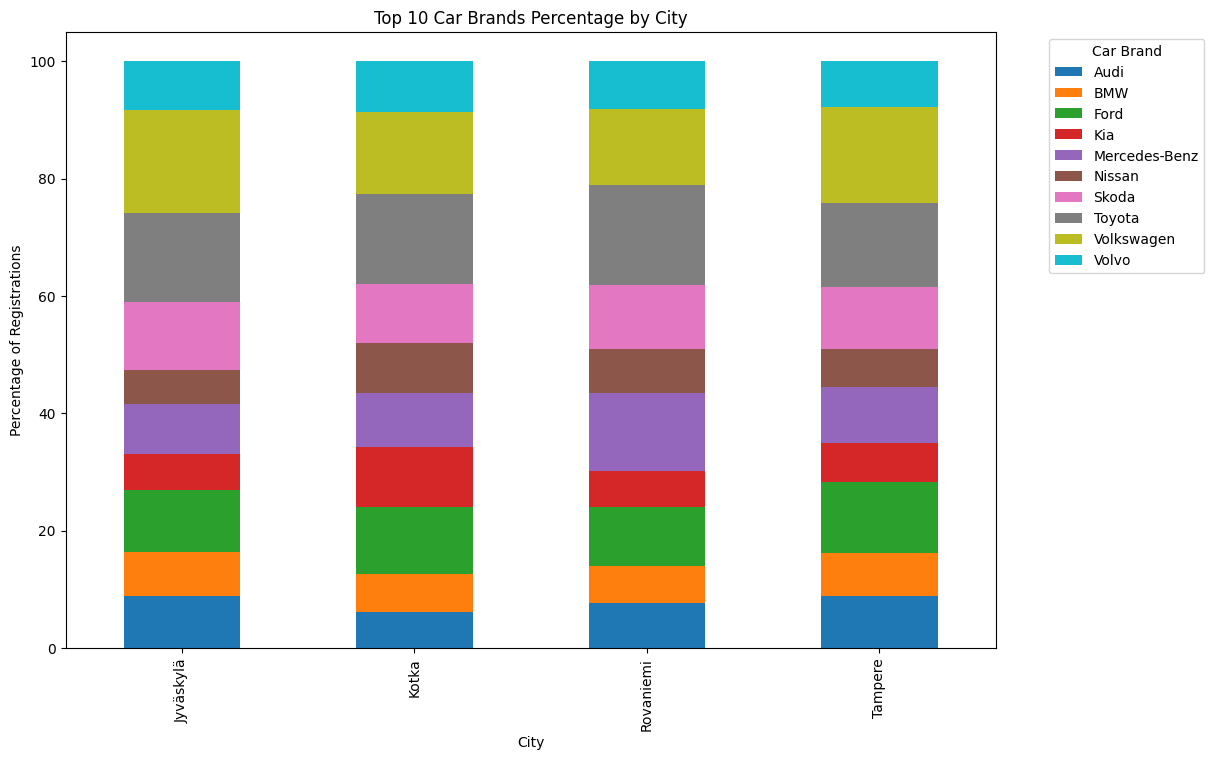

In [25]:
df = kk.ensirekisteroinnit_kunnittain_ajoneuvoluokassa("01.01.2010", "01.01.2016", "M1",["Rovaniemi", "Jyväskylä","Tampere","Kotka"], False)

# Calculate the total registrations for each car brand
brand_totals = df.groupby('Merkki')['Määrä'].sum()

# Get the top 10 most sold car brands
top_brands = brand_totals.sort_values(ascending=False).head(10).index

# Filter the DataFrame to include only the top 10 car brands
df_top10 = df[df['Merkki'].isin(top_brands)]

# Pivot the DataFrame to have cities as columns and car brands as rows
df_pivot = df_top10.pivot_table(index='kunta', columns='Merkki', values='Määrä', aggfunc='sum')

# Calculate the percentage of total registrations for each car brand within each city
df_percentage = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# Plotting
ax = df_percentage.plot(kind='bar', stacked=True, figsize=(12, 8))

# Adding labels and title
ax.set_xlabel('City')
ax.set_ylabel('Percentage of Registrations')
ax.set_title('Top 10 Car Brands Percentage by City')

# Show the legend
ax.legend(title='Car Brand', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


Cursor created successfully


<Figure size 1500x800 with 0 Axes>

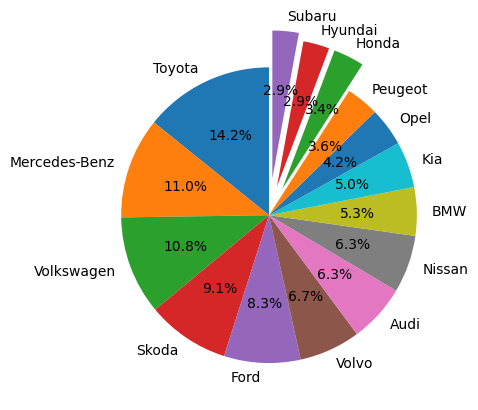

In [15]:
df = kk.ensirekisteroinnit_kunnittain_ajoneuvoluokassa("01.01.2010", "01.01.2016", "M1", "Rovaniemi",False)
df = df.iloc[:15]

plt.figure(figsize=(15, 8))

# Create a pie chart with exploded slices
explode = (0, 0, 0, 0, 0, 0, 0, 0,0 ,0, 0, 0, 0.2, 0.2 ,0.25)  # Adjust the explode values as needed
fig, ax = plt.subplots()
ax.pie(df["Määrä"], labels=df["Merkki"].values, autopct='%1.1f%%', startangle=90, explode=explode)


#ax.set_title('Ajoneuvoluokkien osuudet')

plt.show()


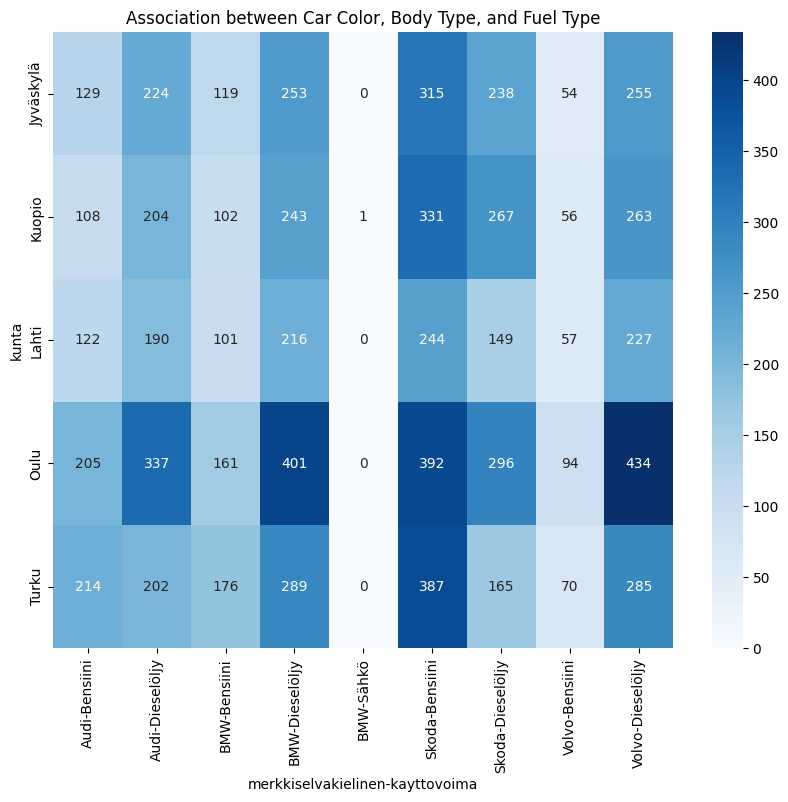

In [27]:
df = kk.rekisteroityjen_autojen_tiedot_aikavalilla(2015, 2016)
df.head()

plt.figure(figsize=(10, 8))

selected_kunta_values = ["Oulu", "Turku", "Jyväskylä", "Kuopio", "Lahti"]  # Add the specific values you want to include
df_filtered = df[df["kunta"].isin(selected_kunta_values)]

selected_merkki_values = ["BMW", "Volvo", "Audi", "Skoda"] 
df_filtered = df_filtered[df_filtered["merkkiselvakielinen"].isin(selected_merkki_values)]

selected_kayttovoima_values = ['Bensiini', 'Dieselöljy', 'Sähkö', 'Bensiini/Sähkö','Diesel/Sähkö']
df_filtered = df_filtered[df_filtered["kayttovoima"].isin(selected_kayttovoima_values)]

# Example for the heatmap of associations between 'vari', 'korityyppi', and 'kayttovoima'
associations = pd.crosstab(index=df_filtered['kunta'], columns=[df_filtered['merkkiselvakielinen'],df_filtered["kayttovoima"]])
sns.heatmap(associations, cmap='Blues', annot=True, fmt='d')
plt.title('Association between Car Color, Body Type, and Fuel Type')
plt.show()

In [11]:
df = kk.ensirekisteroinnit_vuosittain_henkiloauto_luokassa(2015, 2016)
df.head()

Cursor created successfully


,yhteensa,vuosi2015,vuosi2016
0,1884066,116101,124856


In [44]:
#otetaanko vaan tietyt kunnat esim missä tämä autokauppa toimii
df = kk.rekisteroityjen_autojen_tiedot_aikavalilla(2015, 2016)
df.head()

Cursor created successfully


,merkkiselvakielinen,vari,korityyppi,ohjaamotyyppi,istumapaikkojenlkm,omamassa,kayttovoima,iskutilavuus,suurinnettoteho,sylintereidenlkm,ahdin,sahkohybridi,vaihteistotyyppi,vaihteidenlkm,kunta,matkamittarilukema
0,Audi,Musta,Sedan (AA),None,5,1310,Bensiini,1395,92,4,True,False,Automaattinen,7.0,Vaasa,56928
1,Audi,Musta,Sedan (AA),None,5,1365,Dieselöljy,1598,81,4,True,False,Automaattinen,7.0,Oulu,101059
2,Audi,Musta,Sedan (AA),None,5,1390,Dieselöljy,1968,110,4,True,False,Käsivalintainen,6.0,Seinäjoki,138663
3,Audi,Musta,Sedan (AA),None,5,1455,Bensiini,1798,132,4,True,False,Automaattinen,6.0,Jyväskylä,115772
4,Audi,Musta,Sedan (AA),None,5,1455,Bensiini,1798,132,4,True,False,Automaattinen,6.0,Raisio,64284


In [43]:
# Voisiko tässä olla hypoteesi jotenkin niin, että kuntien välillä ei ole eroa tms tai sitten katsoa kahta kuntaa esim

import pandas as pd
from scipy.stats import chi2_contingency
# Assuming 'your_categorical_variable1' and 'your_categorical_variable2' are categorical variables
# Replace them with the actual column names from your dataset
df = kk.rekisteroityjen_autojen_tiedot_aikavalilla(2015, 2016)
selected_cities = ["Helsinki", "Jyväskylä", "Tampere"]

# Filter the DataFrame
filtered_df = df[df['kunta'].isin(selected_cities)]

crosstab = pd.crosstab(filtered_df['kunta'], filtered_df['merkkiselvakielinen'])
print(crosstab)
# Perform chi-squared test for independence
chi2, p, _, _ = chi2_contingency(crosstab)

# Print the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")


Cursor created successfully
merkkiselvakielinen  Adria  Alfa Romeo  Alpina  Aston Martin  Audi  \
kunta                                                                
Helsinki                11          31       1             5  1290   
Jyväskylä                5           0       0             0   356   
Tampere                  9          12       0             0   603   

merkkiselvakielinen  Autocaravans Rimor S.p.A   BMW  BMW i  Bentley  Buick  \
kunta                                                                        
Helsinki                                    1  1396     10        4      1   
Jyväskylä                                   0   372      0        0      2   
Tampere                                     0   583      2        1      2   

merkkiselvakielinen  Burstner  Burstner GmbH  Bürstner GmbH  Cadillac  Capron  \
kunta                                                                           
Helsinki                    1              0              0         

# Yhteenveto